---
title: Bayesian HMM
jupyter: python3
---

# Import and clean data

In [1]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from pyprojroot import here
import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.optim import Adam
from scipy.stats import poisson
import torch
import seaborn as sns

data = pd.read_csv(here("data/recent_donations.csv"))
data

# remove columns y_2020 to y_2023
# data = data.drop(columns=["y_2020", "y_2021", "y_2022", "y_2023"])

,unique_number,class_year,birth_year,first_donation_year,gender,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015,y_2016,y_2018,y_2019,y_2017,y_2020,y_2021,y_2022,y_2023
0,26308560,"(1960,1970]",1965,1985,M,0,0,0,0,0,0,0,0,0,0,0,1,1,3,1
1,26309283,"(1960,1970]",1966,2002,M,2,1,2,2,1,1,3,3,4,1,3,3,3,3,4
2,26317365,"(1960,1970]",1961,1984,M,4,2,3,3,3,4,3,3,2,3,3,2,0,1,0
3,26318451,"(1960,1970]",1967,1989,M,0,3,3,4,4,4,2,3,3,1,2,3,1,0,0
4,26319465,"(1960,1970]",1964,1994,F,1,2,2,1,2,1,1,0,0,2,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,27220599,"(1970,1980]",1980,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9232,27220806,"(2000,2010]",2002,2022,M,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3
9233,27221247,"(1990,2000]",2000,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
9234,27221274,"(1960,1970]",1966,2022,F,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3


In [ ]:
# ------------------------------------------------------------------
# Required libraries
# ------------------------------------------------------------------
import polars as pl
import numpy as np
import torch

# ------------------------------------------------------------------
# 1. Load data into a Polars DataFrame
# ------------------------------------------------------------------
# df = pl.read_csv("file.csv")          # Uncomment if reading from file
df = pl.from_pandas(data)               # Convert from pandas if already in memory

# ------------------------------------------------------------------
# 2. Collect year columns and build the observation matrix [N, T]
# ------------------------------------------------------------------
year_cols = sorted([c for c in df.columns if c.startswith("y_")])
T = len(year_cols)

obs = (
    df.select(year_cols)                # Select y_* columns
      .fill_null(0)                     # Replace NaNs by 0
      .to_numpy()
      .astype(int)                      # Ensure integer type
)

# ------------------------------------------------------------------
# 3. Create fixed covariates per individual
# ------------------------------------------------------------------
df = df.with_columns(
    [
        (pl.col("gender") == "F").cast(pl.Int8).alias("gender_code"),      # 0 = M, 1 = F
        (
            (pl.col("birth_year") - pl.col("birth_year").mean()) /
            pl.col("birth_year").std()
        ).alias("birth_year_norm")                                         # Standardised birth year
    ]
)

birth_year_norm = df["birth_year_norm"].to_numpy()    # Shape [N]
gender_code     = df["gender_code"].to_numpy()        # Shape [N]

# ------------------------------------------------------------------
# 4. Build dynamic covariates (age and COVID dummy)
# ------------------------------------------------------------------
years_num = np.array([int(c[2:]) for c in year_cols])                 # e.g. [2009, …, 2023]
ages      = years_num[None, :] - df["birth_year"].to_numpy()[:, None] # Shape [N, T]
ages_norm = (ages - ages.mean()) / ages.std()                         # Standardised age

covid_years = np.isin(years_num, [2020, 2021, 2022]).astype(float)    # Shape [T]
covid_years = np.tile(covid_years, (df.height, 1))                    # Shape [N, T]

# ------------------------------------------------------------------
# 5. Assemble the full covariate tensor [N, T, 5]
#    Order: birth_year_norm, gender_code, ages_norm, covid_years, const
# ------------------------------------------------------------------
base_cov  = np.stack([birth_year_norm, gender_code], axis=1)          # Shape [N, 2]
base_cov  = np.repeat(base_cov[:, None, :], T, axis=1)                # [N, T, 2]

dyn_cov   = np.stack([ages_norm, covid_years], axis=2)                # [N, T, 2]

const_cov = np.ones((df.height, T, 1), dtype=np.float32)              # Constant term

full_cov  = np.concatenate([base_cov, dyn_cov, const_cov], axis=2)    # [N, T, 5]
cov_names = ["birth_year_norm",
             "gender_code",
             "ages_norm",
             "covid_years",
             "const"]

# ------------------------------------------------------------------
# 6. Convert to PyTorch tensors (optional)
# ------------------------------------------------------------------
obs_torch      = torch.tensor(obs,      dtype=torch.long)
full_cov_torch = torch.tensor(full_cov, dtype=torch.float)

# ------------------------------------------------------------------
# 7. Quick sanity check
# ------------------------------------------------------------------
print("obs       :", obs.shape)        # (N, T)
print("covariates:", full_cov.shape)   # (N, T, 5)
print("order     :", cov_names)        # Confirm column order

obs       : (9236, 15)
covariates: (9236, 15, 5)
order     : ['birth_year_norm', 'gender_code', 'ages_norm', 'covid_years', 'const']


## Model

3-state Poisson Hidden Markov Model

$$
\begin{aligned}
\pi &\sim \text{Dirichlet}(\mathbf 1) \\[4pt]
A_{k\cdot} &\sim \text{Dirichlet}(\mathbf 1)\qquad\forall k \\[4pt]
z_0 &\sim \text{Categorical}(\pi),\qquad 
z_t \mid z_{t-1}\sim\text{Categorical}\!\bigl(A_{z_{t-1}\cdot}\bigr) \\[4pt]
\lambda_k &\sim \text{Gamma}(2,1) \\[4pt]
y_t \mid z_t=k &\sim \text{Poisson}(\lambda_k)
\end{aligned}
$$

The discrete chains $(z_{n,t})$ are **marginalised exactly** via enumeration.

Guide (mean-field)

$$
q(\pi)=\text{Dirichlet}(\boldsymbol{\alpha}_\pi),\qquad 
q(A_{k\cdot})=\text{Dirichlet}(\boldsymbol{\alpha}_{A_k}),\qquad
q(\lambda_k)=\text{Gamma}(\alpha_k,\beta_k)
$$

Hence  


$$
q(\pi,A,\lambda)=q(\pi)\,\prod_k q(A_{k\cdot})\,q(\lambda_k)
$$

with no cross-covariances; the $(z)$’s remain *exact*.

Training

* Optimiser: **Adam** (learning-rate = 0.05)  
* Inference: **Stochastic Variational Inference**  
* Loss: `TraceEnum_ELBO(max_plate_nesting=1)`

During training the ELBO descends from ≈ 174 k to ≈ 130 k.  
After convergence we report the posterior means  
$(\hat{\pi},\ \hat{A},\ \hat{\lambda})$ together with their Dirichlet/Gamma
uncertainty.

In [3]:
K = 3              # n. stati latenti


# ------------------------------------------------------------------ #
#  MODEL                                                             #
# ------------------------------------------------------------------ #
def model(obs):
    N, T = obs.shape

    # π   (prob. iniziali)  – una sola Dirichlet
    pi = pyro.sample("pi", dist.Dirichlet(torch.ones(K)))              # [K]

    # A   (matrice di transizione)  – K Dirichlet, una per riga
    with pyro.plate("row", K):
        A = pyro.sample("A", dist.Dirichlet(torch.ones(K)))            # [K,K]

    # tassi Poisson
    rates = pyro.sample("rates",
                        dist.Gamma(2.*torch.ones(K),
                                   1.*torch.ones(K)).to_event(1))      # [K]

    # osservazioni
    with pyro.plate("donor", N):
        z = pyro.sample("z_0", dist.Categorical(pi),
                        infer={"enumerate": "parallel"})

        for t in pyro.markov(range(T)):
            pyro.sample(f"y_{t}", dist.Poisson(rates[z]),
                        obs=obs[:, t])
            if t < T-1:
                z = pyro.sample(f"z_{t+1}", dist.Categorical(A[z]),
                                infer={"enumerate": "parallel"})


# ------------------------------------------------------------------ #
#  GUIDE                                                             #
# ------------------------------------------------------------------ #
def guide(obs):
    # variational params
    pi_alpha    = pyro.param("pi_alpha",
                             torch.ones(K),
                             constraint=dist.constraints.positive)     # [K]

    A_alpha     = pyro.param("A_alpha",
                             torch.ones(K, K),
                             constraint=dist.constraints.positive)     # [K,K]

    r_alpha     = pyro.param("r_alpha",
                             2.*torch.ones(K),
                             constraint=dist.constraints.positive)     # [K]
    r_beta      = pyro.param("r_beta",
                             1.*torch.ones(K),
                             constraint=dist.constraints.positive)

    pyro.sample("pi", dist.Dirichlet(pi_alpha))

    with pyro.plate("row", K):
        pyro.sample("A", dist.Dirichlet(A_alpha))

    pyro.sample("rates", dist.Gamma(r_alpha, r_beta).to_event(1))


# ------------------------------------------------------------------ #
#  TRAINING                                                          #
# ------------------------------------------------------------------ #
pyro.clear_param_store()
svi = SVI(model, guide, Adam({"lr": 0.05}),
          loss=TraceEnum_ELBO(max_plate_nesting=1))

for step in range(1000):
    loss = svi.step(obs_torch)
    if step % 100 == 0:
        print(f"{step:4d}  ELBO = {loss:,.0f}")


# ------------------------------------------------------------------ #
#  PARAMETRI “MEAN” DOPO IL TRAINING                                 #
# ------------------------------------------------------------------ #
with torch.no_grad():
    pi_mean = pyro.param("pi_alpha")
    pi_mean = pi_mean / pi_mean.sum()

    A_alpha = pyro.param("A_alpha")
    A_mean  = A_alpha / A_alpha.sum(dim=1, keepdim=True)   # somma 1 per riga

    rates   = pyro.param("r_alpha") / pyro.param("r_beta")

print("\nπ:", pi_mean.numpy())
print("\nA (ogni riga somma a 1):\n", A_mean.numpy())
print("\nrates:", rates.numpy())

   0  ELBO = 240,511
 100  ELBO = 134,404
 200  ELBO = 133,948
 300  ELBO = 133,129
 400  ELBO = 143,419
 500  ELBO = 139,711
 600  ELBO = 141,604
 700  ELBO = 132,498
 800  ELBO = 134,011
 900  ELBO = 131,976

π: [0.75274813 0.16354445 0.08370742]

A (ogni riga somma a 1):
 [[0.87137127 0.0324327  0.09619594]
 [0.00590259 0.9655163  0.02858107]
 [0.00480633 0.00386194 0.9913317 ]]

rates: [0.00568039 2.2061214  0.9344917 ]


• ELBO steadily decreases from ≈174 k to ≈130 k and then plateaus → optimisation has mostly converged.

• Initial-state distribution π – State 0 dominates (74 %), followed by state 1 (18 %); state 2 is rare (8 %). – Most donors start in state 0.

• Transition matrix A – Strong self-persistence: P(0 → 0)=0.88, P(1 → 1)=0.98, P(2 → 2)=0.99. – Cross-state moves are all \< 9 %; once a donor is in a state, they tend to stay there.

• Poisson rates – State 0: λ≈0.006 (almost no donations) – State 1: λ≈2.42 (frequent donors) – State 2: λ≈0.83 (occasional donors)

Interpretation: the model has discovered three very stable behavioural profiles—non-donors, heavy donors, and light donors—with rare transitions between them.

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_hmm_params(transitions, initial_probs, emissions,
                    state_names=None, emission_names=None):
    """
    Plotta in una riga:
    - Matrice di transizione [S, S]
    - Prob iniziali [S]
    - Matrice emissioni [S, K]
    """
    S = len(initial_probs)
    K = emissions.shape[1]
    if state_names is None:
        state_names = [f"State {i}" for i in range(S)]
    if emission_names is None:
        emission_names = [str(i) for i in range(K)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Initial probabilities
    axs[0].bar(np.arange(S), initial_probs, color='royalblue')
    axs[0].set_title('Initial State Probabilities')
    axs[0].set_xlabel('State')
    axs[0].set_ylabel('Probability')
    axs[0].set_xticks(np.arange(S))
    axs[0].set_xticklabels(state_names)
    axs[0].grid(axis='y', alpha=0.3)

    # Transition matrix
    sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Greens',
                xticklabels=state_names, yticklabels=state_names, ax=axs[1], cbar=False)
    axs[1].set_title('Transition Probabilities')
    axs[1].set_xlabel('Next State')
    axs[1].set_ylabel('Current State')

    # Emission probabilities/matrix
    sns.heatmap(emissions, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=emission_names, yticklabels=state_names, ax=axs[2], cbar=False)
    axs[2].set_title('Emission Probabilities')
    axs[2].set_xlabel('Donations in a Year')
    axs[2].set_ylabel('Latent State')

    plt.tight_layout()
    plt.show()

def build_emission_matrix_truncated_poisson(rates, max_k=4):
    S = len(rates)
    K = max_k + 1   # da 0 a max_k incluso
    emissions = np.zeros((S, K))
    for s in range(S):
        for k in range(max_k):
            emissions[s, k] = poisson.pmf(k, rates[s])
        # L'ultimo raccoglie la coda (tutto >= max_k)
        emissions[s, max_k] = 1 - poisson.cdf(max_k-1, rates[s])
    return emissions

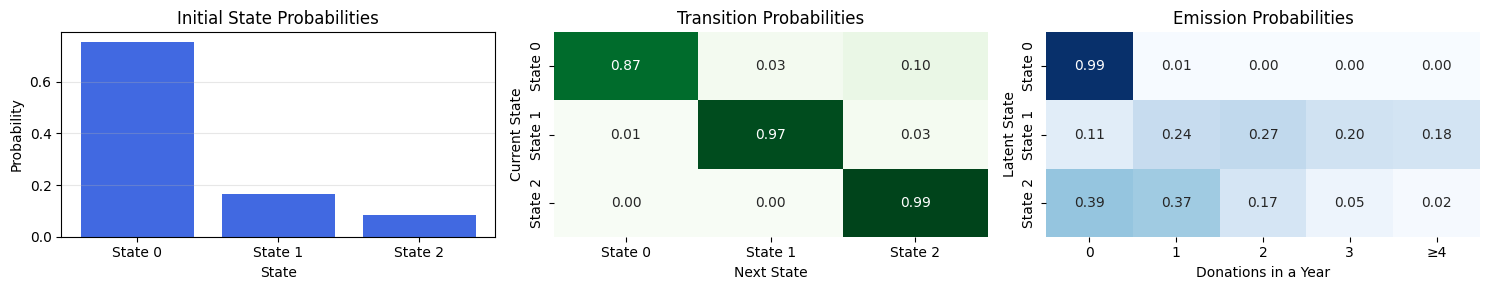

In [5]:
emissions_matrix = build_emission_matrix_truncated_poisson(rates, max_k=4)

plot_hmm_params(
    transitions=A_mean,
    initial_probs=pi_mean,
    emissions=emissions_matrix,
    emission_names=[str(i) for i in range(4)] + ["≥4"]
)

# Diagnostics

## Viterbi Algorithm

Viterbi decoder\
Goal : for each donor find the MAP latent path $z_{0:T}^\ast$.

Plug-in parameters (posterior means)\
$$\hat\pi_k = \frac{\alpha_{\pi,k}}{\sum_{j}\alpha_{\pi,j}},\qquad
  \hat A_{kj} = \frac{\alpha_{A_{k j}}}{\sum_{j'}\alpha_{A_{k j'}}},\qquad
  \hat\lambda_k = \frac{\alpha_k}{\beta_k}.$$

Dynamic programming\
Initial step\
$$\delta_0(k)=\log\hat\pi_k+\log\text{Poisson}(y_0\mid\hat\lambda_k).$$

Recursion for $t=1,\dots,T$\
$$\delta_t(j)=\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr]
               +\log\text{Poisson}(y_t\mid\hat\lambda_j),$$\
$$\psi_t(j)=\arg\max_k\bigl[\delta_{t-1}(k)+\log\hat A_{k j}\bigr].$$

Back-tracking\
Start with $z_T^\ast=\arg\max_k\delta_T(k)$, then\
$z_{t-1}^\ast=\psi_t(z_t^\ast)$ for $t=T,\dots,1$.

Cost $O(NTK^2)$ but vectorised in PyTorch, so only a loop on $t$.\
Output tensor paths\[N,T\] of integers 0…K-1, used for diagnostics and plots.

In [6]:
def viterbi_paths_poisson(obs,      # LongTensor [N,T]
                          K=3):     # # latent states
    """
    Returns the most-likely latent path for every individual
    using the current variational parameters of the Poisson HMM.
    """
    with torch.no_grad():
        # ----- expected model parameters ---------------------------------
        # initial probs π
        pi_alpha = pyro.param("pi_alpha")                  # [K]
        pi_prob  = pi_alpha / pi_alpha.sum()               # [K]
        log_pi   = pi_prob.log()

        # transition matrix A
        A_alpha  = pyro.param("A_alpha")                   # [K,K]
        A_prob   = A_alpha / A_alpha.sum(1, keepdim=True)  # rows sum 1
        log_A    = A_prob.log()

        # Poisson rates λ
        r_alpha  = pyro.param("r_alpha")                   # [K]
        r_beta   = pyro.param("r_beta")
        rates    = r_alpha / r_beta                       # [K]

        # ----- pre-compute emission log-probs ----------------------------
        N, T = obs.shape
        emis_log = dist.Poisson(rates).log_prob(obs.unsqueeze(-1))  # (N,T,K)

        # ----- Viterbi ----------------------------------------------------
        paths  = torch.zeros(N, T, dtype=torch.long)
        psi    = torch.zeros(N, T, K, dtype=torch.long)   # back-pointers
        delta  = log_pi + emis_log[:, 0]                  # (N,K)

        for t in range(1, T):
            # score: delta_prev + log A (broadcast prev→next)
            score = delta.unsqueeze(2) + log_A            # (N,K_prev,K_next)
            delta, psi[:, t] = torch.max(score, dim=1)    # argmax over prev
            delta += emis_log[:, t]                       # add emission

        # back-tracking
        last = torch.argmax(delta, dim=1)                 # (N,)
        paths[:, -1] = last
        for t in range(T - 1, 0, -1):
            last = psi[torch.arange(N), t, last]
            paths[:, t-1] = last

    return paths


# -------------------------------------------------------------------------
paths = viterbi_paths_poisson(obs_torch, K=3).cpu().numpy()

# e.g. fraction of sequences that switch state at least once
switch = (paths[:, 1:] != paths[:, :-1]).any(1).mean()
print(f"Sequences with ≥1 switch: {switch * 100:.1f}%")

Sequences with ≥1 switch: 79.8%


## State occupancy over time (population view)

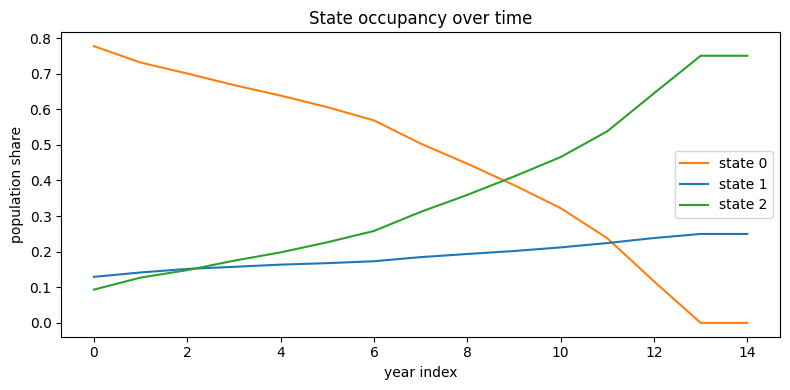

In [7]:
counts = np.apply_along_axis(lambda col: np.bincount(col, minlength=3),
                             0, paths)          # (K,T)
props  = counts / counts.sum(0, keepdims=True)

plt.figure(figsize=(8,4))
for k,c in enumerate(['tab:orange','tab:blue','tab:green']):
    plt.plot(props[k], label=f'state {k}', color=c)
plt.xlabel('year index'); plt.ylabel('population share')
plt.title('State occupancy over time'); plt.legend(); plt.tight_layout()

## Rates with confidence bands

Text(0.5, 1.0, 'Poisson rates with 95% CI')

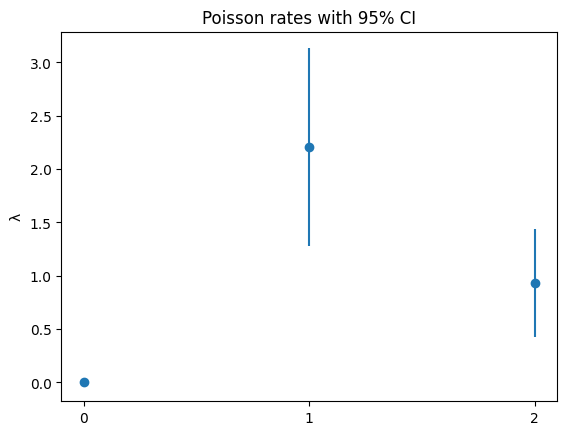

In [8]:
rate_sd   = np.sqrt(pyro.param("r_alpha").detach().numpy()) / pyro.param("r_beta").detach().numpy()
ci = 1.96 * rate_sd
plt.errorbar(np.arange(K), rates, yerr=ci, fmt='o')
plt.xticks(range(K)); plt.ylabel('λ'); plt.title('Poisson rates with 95% CI')

## Network / chord diagram of transitions

A visual alternative to the heat-map, highlights main flows.

C:\Users\erik4\AppData\Local\Programs\Python\Python313\Lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


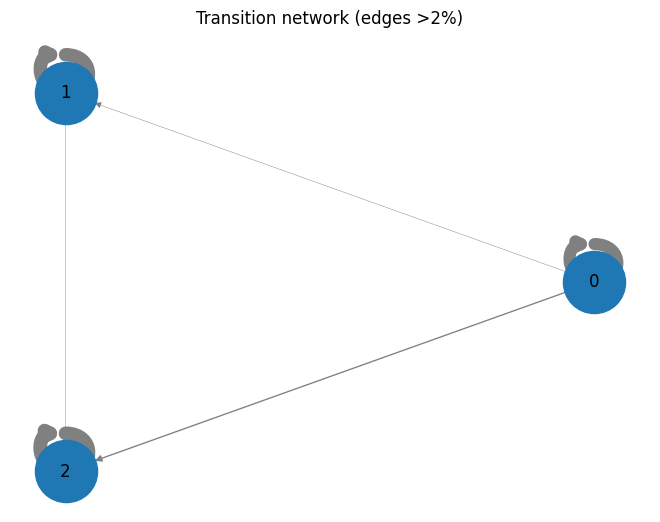

In [9]:
import networkx as nx
G = nx.DiGraph()
for i in range(K):
    for j in range(K):
        if A_mean[i,j] > 0.02:                 # ignore tiny flows
            G.add_edge(i, j, weight=A_mean[i,j])
pos = nx.circular_layout(G)
weights = [G[u][v]['weight']*10 for u,v in G.edges]
nx.draw(G, pos, with_labels=True, width=weights,
        edge_color='grey', node_size=2000, cmap='viridis')
plt.title('Transition network (edges >2%)'); plt.show()

## Individual trajectories

Pick a few donors and overlay observations + decoded state for an easy interpretation of the model.

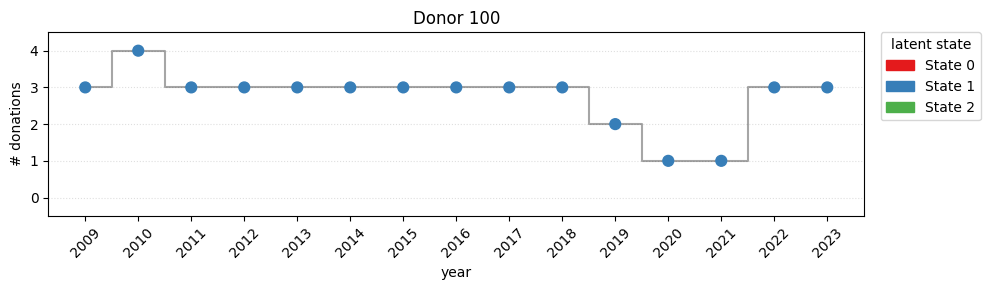

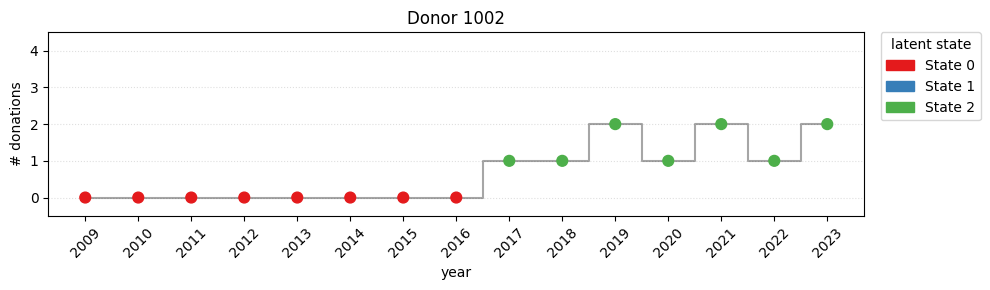

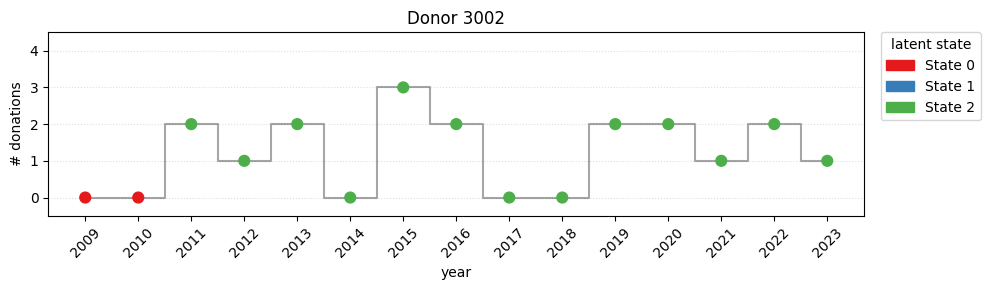

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import numpy as np

# ------------------------------------------------------------
# globals
# ------------------------------------------------------------
K           = 3
state_cols  = ['#e41a1c', '#377eb8', '#4daf4a']          # 3 colori Set1
cmap        = ListedColormap(state_cols)
norm        = BoundaryNorm(np.arange(-0.5, K+0.5, 1), cmap.N)
years_axis  = np.arange(2009, 2024)                      # 2009 .. 2024
yticks_vals = np.arange(0, 5)                            # 0 .. 4

# ------------------------------------------------------------
def plot_one(idx):
    x = obs_torch[idx].cpu().numpy()       # osservazioni (T,)
    z = paths[idx]                         # stati latenti (T,)
    T = len(x)
    assert T == len(years_axis), "years_axis length must match T"

    plt.figure(figsize=(10, 3))
    plt.scatter(range(T), x, c=z, cmap=cmap, norm=norm, s=60, zorder=3)
    plt.step(range(T), x, where='mid', color='k', alpha=.35, zorder=2)

    # ---------- axis formatting ----------------------------------------
    plt.xticks(ticks=range(T), labels=years_axis, rotation=45)
    plt.yticks(ticks=yticks_vals)
    plt.ylim(-0.5, 4.5)                     # blocca a 0–4
    plt.grid(axis='y', linestyle=':', alpha=.4, zorder=1)

    # ---------- legenda discreta ---------------------------------------
    handles = [Patch(color=state_cols[k], label=f'State {k}') for k in range(K)]
    plt.legend(handles=handles, title='latent state',
               bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    plt.title(f'Donor {idx}')
    plt.xlabel('year')
    plt.ylabel('# donations')
    plt.tight_layout()
    plt.show()


for i in [100, 1002, 3002]:
    plot_one(i)